# Generalization with OOP: The SMABacktester Class

## Using the SMABacktester Class

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [4]:
df = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
df

,AUDEUR=X,EURUSD=X,USDGBP=X
Date,,,
2004-01-01,0.59780,1.258194,0.56016
2004-01-02,0.60314,1.258194,0.55751
2004-01-05,0.60467,1.268698,0.55334
2004-01-06,0.60350,1.272103,0.54906
2004-01-07,0.60728,1.264095,0.55012
...,...,...,...
2020-06-24,0.61349,1.131235,0.79841
2020-06-25,0.60938,1.125087,0.80561
2020-06-26,0.61373,1.122208,0.80480


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4295 entries, 2004-01-01 to 2020-06-30
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AUDEUR=X  4274 non-null   float64
 1   EURUSD=X  4275 non-null   float64
 2   USDGBP=X  4287 non-null   float64
dtypes: float64(3)
memory usage: 134.2 KB


In [6]:
class SMABacktester(): # with ptc 
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [7]:
tester = SMABacktester("EURUSD=X", 50, 200, "2016-01-01", "2021-03-01", 0)

In [6]:
tester

SMABacktester(symbol = EURUSD=X, SMA_S = 50, SMA_L = 200, start = 2016-01-01, end = 2021-03-01)

In [7]:
tester.test_strategy()
#same result from class #33, but here it is automated and faster

(1.048449, 0.044973)

In [8]:
tester.results
#very familiar

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2016-10-07,1.114455,-0.005700,1.120894,1.116654,1,-0.005700,0.0,0.994316,0.994316
2016-10-10,1.119695,0.004692,1.120952,1.116826,1,0.004692,0.0,0.998992,0.998992
2016-10-11,1.114082,-0.005026,1.120897,1.116982,1,-0.005026,0.0,0.993984,0.993984
2016-10-12,1.106195,-0.007105,1.120583,1.117137,1,-0.007105,0.0,0.986947,0.986947
2016-10-13,1.101188,-0.004536,1.120304,1.117254,1,-0.004536,0.0,0.982480,0.982480
...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430,-1,-0.002892,0.0,1.009287,1.038460
2020-06-25,1.125087,-0.005449,1.102486,1.103540,-1,0.005449,0.0,1.003803,1.044134
2020-06-26,1.122208,-0.002562,1.103213,1.103627,-1,0.002562,0.0,1.001234,1.046812


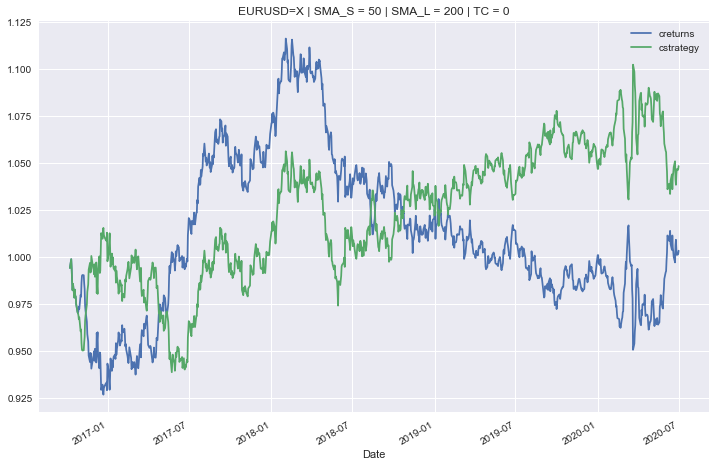

In [9]:
tester.plot_results()

In [10]:
tester.set_parameters(22, 100)

In [11]:
tester.test_strategy()

(0.95102, -0.05114)

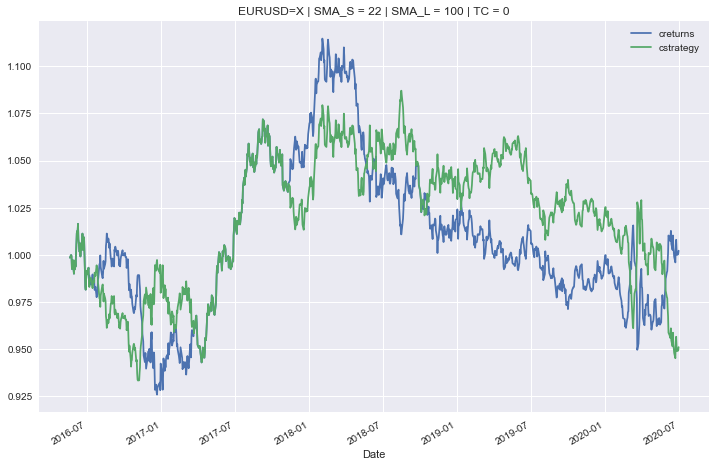

In [12]:
tester.plot_results()

In [13]:
tester.optimize_parameters((25, 50, 1), (100, 200, 1))

(array([ 26., 128.]), 1.175404)

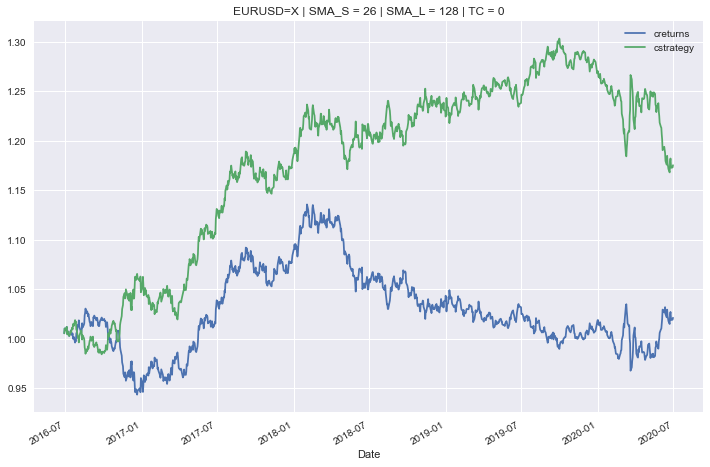

In [14]:
tester.plot_results()
#less ilustrative, but faster and cleaner!!

__Backtesting & Forward Testing__

In [15]:
train = SMABacktester("EURUSD=X", 50, 200, "2004-01-01", "2015-12-31", 0)

In [16]:
train.optimize_parameters((25, 50, 1), (100, 200, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 46., 137.]), 2.440535)

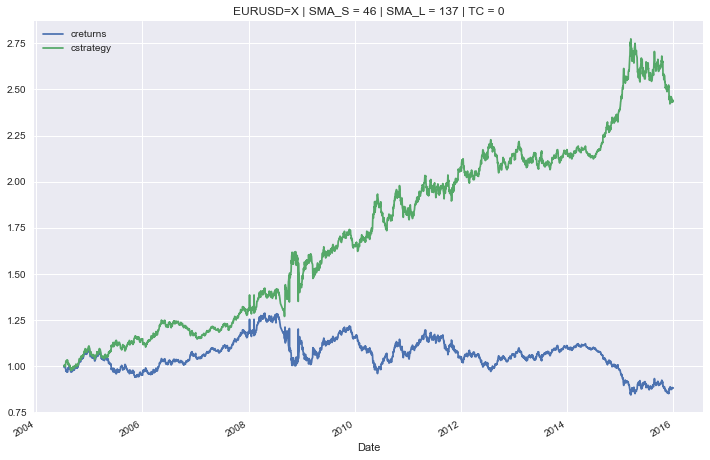

In [17]:
train.plot_results()

In [19]:
#tabajara here. Found best parameters from 2004 to 2016. Now replicating from 2016 to 2020
tester = SMABacktester("EURUSD=X", 46, 137, "2016-01-01", "2020-06-30", 0)

In [20]:
tester.test_strategy() # forward testing ("out-sample")
#check how it did not replicate in future!! not easy

(1.056731, 0.038331)

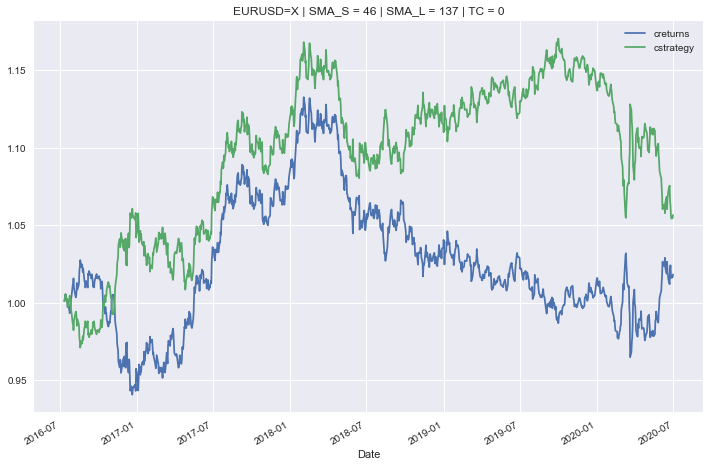

In [21]:
tester.plot_results()

In [22]:
tester = SMABacktester("AUDEUR=X", 50, 200, "2004-01-01", "2020-06-30", 0)

In [23]:
tester.test_strategy()

(1.145599, 0.106464)

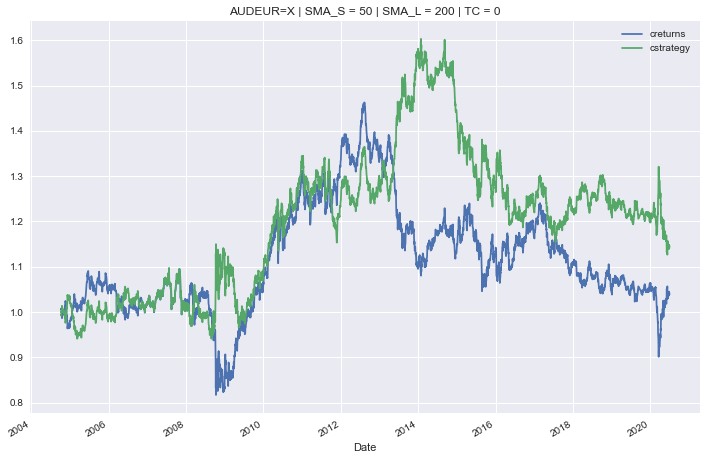

In [24]:
tester.plot_results()

In [25]:
tester.optimize_parameters((25, 50, 1), (100, 200, 1))

(array([ 33., 197.]), 1.457339)

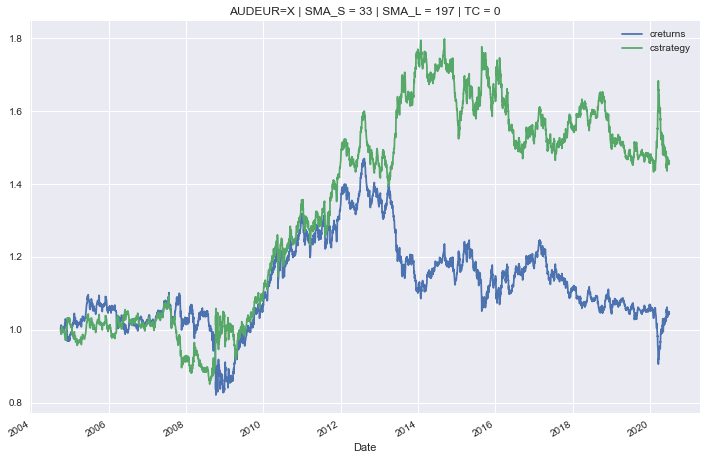

In [26]:
tester.plot_results()

In [27]:
#from 2016 to 2004 is one thing. Whole period another thing. Technical analysis is not straight-forward